1. Nmodes=2
- Rs [40, 80, 160]
- Nch [1,3,5,11,21]
- Pch -2 ~ 8

2. Nmodes=1
- Rs [20, 40, 80, 160]
- Nch [1, 3, 5, 7, 9, 11]
- Pch -8 -6

In [35]:
import h5py
import pickle 
a = pickle.load(open('data/test_data_few.pkl','rb'))

In [38]:
share_info = {
    'D(ps/nm/km)': 16.5,
    'Dpmd(ps/sqrt(km))': 3,
    'Fc(Hz)': 193414489032258.06,
    'Lcorr(km)': 0.1,
    'Lspan(km)': 80,
    'M(QAM-order)': 16,
    'NF(dB)': 4.5,

    # 'Nch': 11,
    # 'Nmodes': 2,
    # 'Pch(dBm)': -1,
    # 'Rs(GHz)': 160,

    'PMD': False,
    'alpha(dB/km)': 0.2,
    'amp': 'edfa',
    'batch': 1,
    'beta2(s^2/km)': -2.1044895291667401e-23,
    'distance(km)': 2000,
    'freqspace(Hz)': 192000000000.0,
    'gamma(/W/km)': 1.6567,
}

In [39]:
import torch 

with h5py.File('dataset_A800/test.h5', 'a') as f:
    for i in range(a[0].y.shape[0]):
        Rs = int(a[0].a['samplerate'][i] / 2e9)
        Nch = a[0].a['channels'][i]
        Pch = a[0].a['lpdbm'][i]
        private_info = {'Nch':Nch, 'Pch(dBm)':Pch, 'Rs(GHz)':Rs, 'Nmodes':1}

        grp = f.create_group(f'Nmodes1_Rs{Rs}_Nch{Nch}_Pch{Pch}_unknown')
        grp.attrs.update(share_info)
        grp.attrs.update(private_info)

        subgrp = grp.create_group('Rx(sps=2,chid=0,method=frequency cut)')
        subgrp.attrs.update({'chid':0, 'method':'frequency cut', 'sps':2})

        data = subgrp.create_dataset('Rx', data=a[0].y[i:i+1])
        data.dims[0].label = 'batch'
        data.dims[1].label = 'time'
        data.dims[2].label = 'modes'
        data.attrs.update({'sps':2, 'start': 0, 'stop': 0, 'Fs(Hz)': Rs*2e9})

        data = subgrp.create_dataset('Tx', data=a[0].x[i:i+1])
        data.dims[0].label = 'batch'
        data.dims[1].label = 'time'
        data.dims[2].label = 'modes'
        data.attrs.update({'sps':1, 'start': 0, 'stop': 0, 'Fs(Hz)': Rs*1e9})


        info = torch.tensor([[Pch, grp.attrs['Fc(Hz)'],  Rs*2e9,  Nch]])
        data = subgrp.create_dataset('info', data=info.cpu().numpy())
        data.dims[0].label = 'batch'
        data.dims[1].label = 'task: Pch, Fi, Rs, Nch'


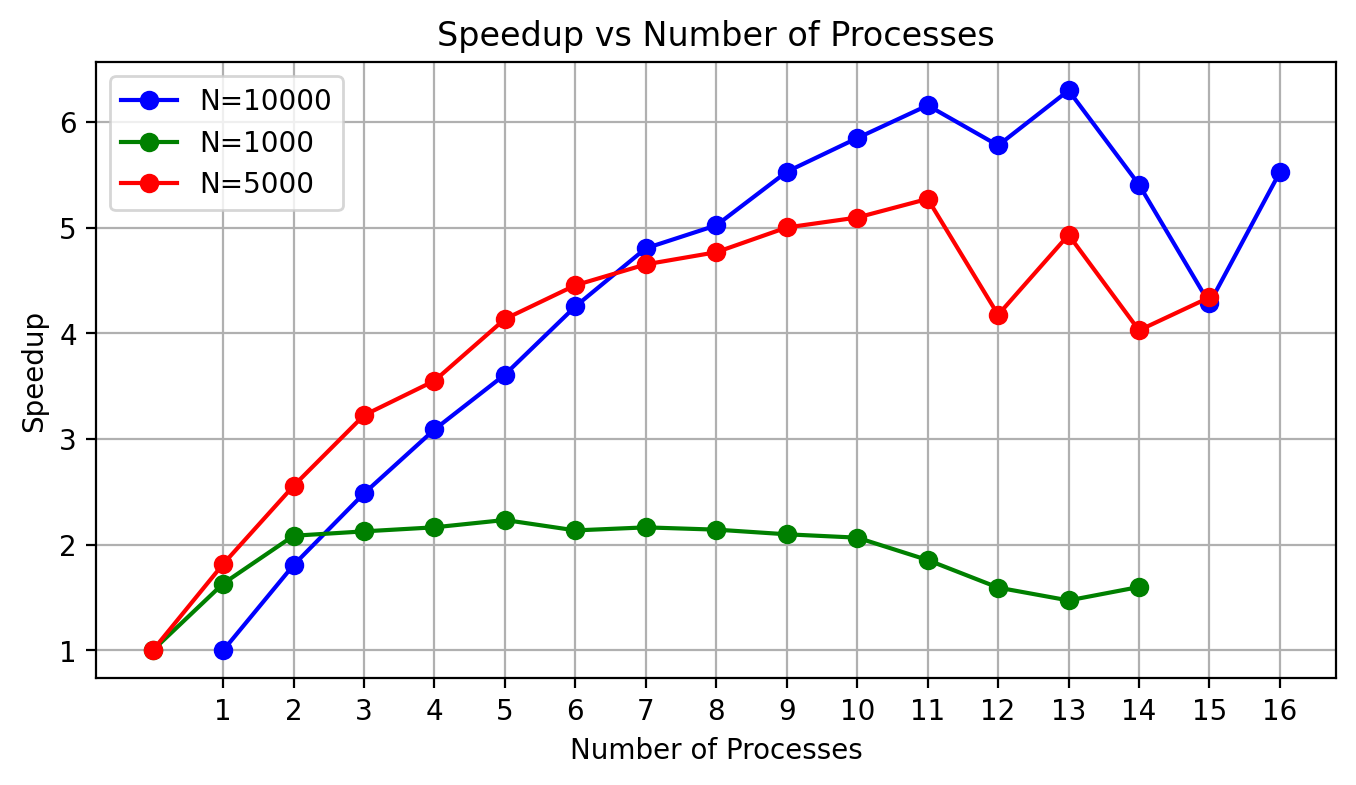

In [13]:
import matplotlib.pyplot as plt

# 数据
serial_time = 8.55659e-05
num_procs = list(range(1, 17))
parallel_times = [
    8.55659e-05, 4.55694e-05, 3.11937e-05, 2.5191e-05, 2.14232e-05, 1.92653e-05,
    1.7056e-05, 1.60284e-05, 1.54373e-05, 1.41594e-05, 1.40193e-05, 1.6512e-05,
    1.52009e-05, 1.56164e-05, 1.47301e-05, 1.57876e-05
]

speedup1 = [serial_time / pt for pt in parallel_times]

serial_time = 7.46985e-05
num_procs = list(range(1, 17))
parallel_times = [
    7.46985e-05, 4.13137e-05, 3.00428e-05, 2.41676e-05, 2.06859e-05,
    1.75532e-05, 1.55437e-05, 1.48724e-05, 1.35084e-05, 1.27729e-05,
    1.21308e-05, 1.29266e-05, 1.18582e-05, 1.38139e-05, 1.74389e-05,
    1.35147e-05
]


# 计算加速比
speedup2 = [serial_time / pt for pt in parallel_times]


serial_time = 1.0078e-05  # 串行执行时间（单位：秒）
parallel_times = [
    1.0078e-05, 6.17428e-06, 4.83273e-06, 4.73855e-06, 4.65463e-06,
    4.51008e-06, 4.71839e-06, 4.65573e-06, 4.70245e-06, 4.8012e-06,
    4.87497e-06, 5.4317e-06, 6.31958e-06, 6.84065e-06, 6.2969e-06
]
speedup3 = [serial_time / pt for pt in parallel_times]

serial_time = 4.27321e-05  # 串行执行时间（单位：秒）
num_procs = list(range(1, 17))  # 进程数
parallel_times = [
    4.27321e-05, 2.35141e-05, 1.67099e-05, 1.32474e-05, 1.20301e-05,
    1.03304e-05, 9.58983e-06, 9.18283e-06, 8.96146e-06, 8.54219e-06,
    8.38436e-06, 8.10388e-06, 1.02322e-05, 8.66312e-06, 1.06059e-05,
    9.8434e-06
]
speedup4 = [serial_time / pt for pt in parallel_times]


# 绘制加速比图像
plt.figure(figsize=(8, 4), dpi=200)
plt.plot(num_procs, speedup2, marker='o', linestyle='-', color='b', label='N=10000')
plt.plot( speedup3, marker='o', linestyle='-', color='g', label='N=1000')
plt.plot( speedup4, marker='o', linestyle='-', color='r', label='N=5000')
plt.xlabel('Number of Processes')
plt.ylabel('Speedup')
plt.title('Speedup vs Number of Processes')
plt.grid(True)
plt.xticks(num_procs)
plt.legend()
plt.show()
